# 47. FastEmbed E5-base 最適化とビットチャンク再評価

## 目的
1. FastEmbed E5-base カスタム登録の最適化（遅い原因特定・チューニング）
2. 64 bits / 96 bits でのOverlapチャンク設定の再評価
3. 外部データ（Wikipedia）での汎化性評価

## 背景
- 実験44: 64 bits でも候補1000件でRecall 99.6%
- 実験45: FastEmbedにE5-baseは公式未サポート → カスタム登録が必要
- 実験46: カスタム登録成功、ただし都度ロードで+176%のオーバーヘッド
- 実験32/33: Overlap(8,4)で128 bitsでRecall 90%達成

## 0. セットアップ

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from tqdm import tqdm
import time
import gc
import psutil
import os

from fastembed import TextEmbedding
from fastembed.common.model_description import PoolingType, ModelSource
from src.itq_lsh import ITQLSH

print('Setup complete')
print(f'Process PID: {os.getpid()}')

Setup complete
Process PID: 3192429


In [3]:
# E5-base カスタム登録
try:
    TextEmbedding.add_custom_model(
        model="intfloat/multilingual-e5-base",
        pooling=PoolingType.MEAN,
        normalization=True,
        sources=ModelSource(hf="intfloat/multilingual-e5-base"),
        dim=768,
        model_file="onnx/model.onnx",
        description="Multilingual E5 base model (custom registered)",
        license="MIT",
        size_in_gb=1.11,
    )
    print("✓ E5-base registered")
except ValueError as e:
    print(f"E5-base: {e}")

✓ E5-base registered


In [4]:
# 定数設定
DB_PATH = '../data/experiment_400k.duckdb'
N_SAMPLES = 5000  # 評価用サンプル数
N_QUERIES = 100   # クエリ数
TOP_K = 10
SEED = 42

MODEL_NAME = 'intfloat/multilingual-e5-base'
MODEL_DIM = 768

In [5]:
# ヘルパー関数
def get_memory_usage():
    """現在のプロセスのメモリ使用量 (MB) を取得"""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024


def hamming_distance_batch(query_hash, candidate_hashes):
    """クエリと候補間のハミング距離を計算"""
    xor_result = np.bitwise_xor(query_hash, candidate_hashes)
    distances = np.sum(np.unpackbits(xor_result, axis=1), axis=1)
    return distances


def hash_to_overlap_segments(hash_array, segment_width=8, stride=4):
    """
    オーバーラップセグメントを生成（N-gram的スライディング）
    
    Args:
        hash_array: (n_samples, n_bytes) のuint8配列
        segment_width: セグメントの幅（ビット数）
        stride: スライド幅（ビット数）
    
    Returns:
        segments: (n_samples, n_segments) の整数配列
    """
    n_samples, n_bytes = hash_array.shape
    n_bits = n_bytes * 8
    
    # ビット列に展開
    bits = np.unpackbits(hash_array, axis=1)
    
    # セグメント数を計算
    n_segments = (n_bits - segment_width) // stride + 1
    
    segments = []
    for i in range(n_segments):
        start = i * stride
        end = start + segment_width
        segment_bits = bits[:, start:end]
        # ビット列を整数に変換
        segment_int = np.packbits(segment_bits, axis=1).view(np.uint8)[:, 0]
        segments.append(segment_int)
    
    return np.column_stack(segments)

## Part 1: FastEmbed E5-base 最適化

### 1.1 現状確認（ベースライン）

In [6]:
# テストテキスト準備
test_texts = [
    "This is a test sentence for embedding.",
    "機械学習は人工知能の一分野です。",
    "FastEmbed is an ONNX-optimized embedding library.",
]

print('=' * 60)
print('ベースライン計測')
print('=' * 60)

ベースライン計測


In [7]:
# ベースライン: 都度ロード
gc.collect()
mem_before = get_memory_usage()

t0 = time.perf_counter()
model = TextEmbedding(MODEL_NAME)
load_time = time.perf_counter() - t0

t0 = time.perf_counter()
list(model.embed(test_texts[:1]))  # 1件のみ
first_inference_time = time.perf_counter() - t0

t0 = time.perf_counter()
list(model.embed(test_texts))
batch_inference_time = time.perf_counter() - t0

mem_after = get_memory_usage()

print(f'\nベースライン結果:')
print(f'  ロード時間: {load_time:.3f}秒')
print(f'  初回推論（1件）: {first_inference_time*1000:.1f}ms')
print(f'  バッチ推論（3件）: {batch_inference_time*1000:.1f}ms')
print(f'  メモリ増加: {mem_after - mem_before:.1f}MB')

baseline_results = {
    'load_time': load_time,
    'first_inference': first_inference_time,
    'batch_inference': batch_inference_time,
    'memory_increase': mem_after - mem_before,
}

del model
gc.collect()


ベースライン結果:
  ロード時間: 2.895秒
  初回推論（1件）: 12.2ms
  バッチ推論（3件）: 26.0ms
  メモリ増加: 1358.7MB


0

### 1.2 cache_dir 明示指定

In [8]:
# cache_dir を明示的に指定してローカルキャッシュを活用
CACHE_DIR = '../data/fastembed_cache'
os.makedirs(CACHE_DIR, exist_ok=True)

gc.collect()
mem_before = get_memory_usage()

t0 = time.perf_counter()
model_cached = TextEmbedding(MODEL_NAME, cache_dir=CACHE_DIR)
load_time_cached = time.perf_counter() - t0

t0 = time.perf_counter()
list(model_cached.embed(test_texts[:1]))
first_inference_cached = time.perf_counter() - t0

t0 = time.perf_counter()
list(model_cached.embed(test_texts))
batch_inference_cached = time.perf_counter() - t0

mem_after = get_memory_usage()

print(f'\ncache_dir指定結果:')
print(f'  ロード時間: {load_time_cached:.3f}秒 (ベースライン: {baseline_results["load_time"]:.3f}秒)')
print(f'  初回推論（1件）: {first_inference_cached*1000:.1f}ms')
print(f'  バッチ推論（3件）: {batch_inference_cached*1000:.1f}ms')
print(f'  メモリ増加: {mem_after - mem_before:.1f}MB')

del model_cached
gc.collect()

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]


cache_dir指定結果:
  ロード時間: 73.545秒 (ベースライン: 2.895秒)
  初回推論（1件）: 13.3ms
  バッチ推論（3件）: 33.3ms
  メモリ増加: 839.4MB


128

### 1.3 lazy_load / providers 設定

In [9]:
# lazy_load=False で事前ロード
gc.collect()
mem_before = get_memory_usage()

t0 = time.perf_counter()
model_eager = TextEmbedding(
    MODEL_NAME, 
    cache_dir=CACHE_DIR,
    lazy_load=False,  # 事前ロード
    providers=['CPUExecutionProvider'],  # CPU明示
)
load_time_eager = time.perf_counter() - t0

t0 = time.perf_counter()
list(model_eager.embed(test_texts[:1]))
first_inference_eager = time.perf_counter() - t0

t0 = time.perf_counter()
list(model_eager.embed(test_texts))
batch_inference_eager = time.perf_counter() - t0

mem_after = get_memory_usage()

print(f'\nlazy_load=False, CPU provider結果:')
print(f'  ロード時間: {load_time_eager:.3f}秒 (ベースライン: {baseline_results["load_time"]:.3f}秒)')
print(f'  初回推論（1件）: {first_inference_eager*1000:.1f}ms')
print(f'  バッチ推論（3件）: {batch_inference_eager*1000:.1f}ms')
print(f'  メモリ増加: {mem_after - mem_before:.1f}MB')

del model_eager
gc.collect()


lazy_load=False, CPU provider結果:
  ロード時間: 1.902秒 (ベースライン: 2.895秒)
  初回推論（1件）: 12.9ms
  バッチ推論（3件）: 33.6ms
  メモリ増加: 732.7MB


0

### 1.4 モデル常駐パターン

In [10]:
# モデル常駐時の推論性能
print('=' * 60)
print('モデル常駐パターン検証')
print('=' * 60)

# 最適設定でモデルロード
model_resident = TextEmbedding(
    MODEL_NAME,
    cache_dir=CACHE_DIR,
    lazy_load=False,
    providers=['CPUExecutionProvider'],
)

# ウォームアップ
_ = list(model_resident.embed(["warmup"]))

# 複数回推論のレイテンシ測定
n_trials = 10
latencies_1 = []
latencies_10 = []
latencies_100 = []

for _ in range(n_trials):
    t0 = time.perf_counter()
    list(model_resident.embed(test_texts[:1]))
    latencies_1.append(time.perf_counter() - t0)

print(f'\n常駐モデル推論レイテンシ (1件):')
print(f'  平均: {np.mean(latencies_1)*1000:.1f}ms')
print(f'  std:  {np.std(latencies_1)*1000:.1f}ms')
print(f'  min:  {np.min(latencies_1)*1000:.1f}ms')
print(f'  max:  {np.max(latencies_1)*1000:.1f}ms')

モデル常駐パターン検証

常駐モデル推論レイテンシ (1件):
  平均: 12.4ms
  std:  0.1ms
  min:  12.3ms
  max:  12.6ms


### 1.5 最適化結果まとめ

In [11]:
print('=' * 60)
print('Part 1: FastEmbed最適化 まとめ')
print('=' * 60)
print(f'''
■ 推奨設定:
  model = TextEmbedding(
      "{MODEL_NAME}",
      cache_dir="{CACHE_DIR}",
      lazy_load=False,
      providers=["CPUExecutionProvider"],
  )

■ ベストプラクティス:
  1. モデルインスタンスを常駐させる（都度生成しない）
  2. cache_dirを明示指定してローカルキャッシュ活用
  3. ウォームアップ推論を初期化時に実行
''')

Part 1: FastEmbed最適化 まとめ

■ 推奨設定:
  model = TextEmbedding(
      "intfloat/multilingual-e5-base",
      cache_dir="../data/fastembed_cache",
      lazy_load=False,
      providers=["CPUExecutionProvider"],
  )

■ ベストプラクティス:
  1. モデルインスタンスを常駐させる（都度生成しない）
  2. cache_dirを明示指定してローカルキャッシュ活用
  3. ウォームアップ推論を初期化時に実行



---

## Part 2: Overlapチャンク評価（64 bits）

### 2.1 テストデータ準備と埋め込み生成

In [12]:
# experiment_400kからサンプリング
conn = duckdb.connect(DB_PATH, read_only=True)

df_sample = conn.execute(f'''
    SELECT id, text, lang
    FROM documents
    ORDER BY hash(id + {SEED})
    LIMIT {N_SAMPLES}
''').fetchdf()

texts = df_sample['text'].tolist()

print(f'テストテキスト数: {len(texts)}')
print(f'言語分布:')
print(df_sample['lang'].value_counts())

conn.close()

テストテキスト数: 5000
言語分布:
lang
en    2504
ja    2496
Name: count, dtype: int64


In [13]:
# 埋め込み生成（常駐モデル使用）
print('埋め込み生成中...')
t0 = time.time()
embeddings = np.array(list(model_resident.embed(texts))).astype(np.float32)
embed_time = time.time() - t0

print(f'\n埋め込み完了:')
print(f'  Shape: {embeddings.shape}')
print(f'  時間: {embed_time:.2f}秒 ({len(texts)/embed_time:.1f} texts/sec)')

埋め込み生成中...

埋め込み完了:
  Shape: (5000, 768)
  時間: 1271.89秒 (3.9 texts/sec)


### 2.2 ITQ学習（64 bits）

In [14]:
# 64 bits ITQ学習
N_BITS_64 = 64

print(f'ITQ学習（{N_BITS_64} bits）...')
t0 = time.time()
itq_64 = ITQLSH(n_bits=N_BITS_64, n_iterations=50, seed=SEED)
itq_64.fit(embeddings)
train_time_64 = time.time() - t0

# ハッシュ生成
hashes_64 = itq_64.transform(embeddings)

print(f'\n64 bits ITQ学習完了:')
print(f'  学習時間: {train_time_64:.2f}秒')
print(f'  ハッシュ shape: {hashes_64.shape}')

ITQ学習（64 bits）...
ITQ学習開始: samples=5000, dim=768, bits=64
  Centering完了: mean_norm=0.8608
  PCA完了: explained_variance=47.75%
  ITQ iteration 10: quantization_error=0.9292
  ITQ iteration 20: quantization_error=0.9287
  ITQ iteration 30: quantization_error=0.9285
  ITQ iteration 40: quantization_error=0.9284
  ITQ iteration 50: quantization_error=0.9283
ITQ学習完了

64 bits ITQ学習完了:
  学習時間: 0.17秒
  ハッシュ shape: (5000, 64)


### 2.3 Overlap設定別評価（64 bits）

In [15]:
# Overlap設定
OVERLAP_CONFIGS_64 = [
    {'name': 'A-64', 'width': 8, 'stride': 4, 'desc': '標準設定'},
    {'name': 'B-64', 'width': 8, 'stride': 2, 'desc': '高精度'},
    {'name': 'C-64', 'width': 16, 'stride': 8, 'desc': '高速'},
]

CANDIDATE_SIZES = [100, 200, 500, 1000, 2000]

def evaluate_overlap_recall(embeddings, hashes, overlap_configs, candidate_sizes, 
                            top_k=10, n_queries=100, seed=42):
    """Overlap設定別のRecallを評価"""
    rng = np.random.default_rng(seed)
    n_docs = len(embeddings)
    query_indices = rng.choice(n_docs, min(n_queries, n_docs), replace=False)
    
    results = {}
    
    for config in overlap_configs:
        name = config['name']
        width = config['width']
        stride = config['stride']
        
        # Overlapセグメント生成
        segments = hash_to_overlap_segments(hashes, segment_width=width, stride=stride)
        n_segments = segments.shape[1]
        
        print(f"\n{name} (width={width}, stride={stride}): {n_segments}セグメント")
        
        config_results = {k: [] for k in candidate_sizes}
        step1_counts = []
        
        for qi in tqdm(query_indices, desc=f'Evaluating {name}'):
            query_emb = embeddings[qi]
            query_segments = segments[qi]
            
            # Ground truth
            cosines = embeddings @ query_emb / (norm(embeddings, axis=1) * norm(query_emb) + 1e-10)
            gt_set = set(np.argsort(cosines)[-top_k:])
            
            # Step 1: Overlapセグメント一致でフィルタ（OR条件）
            match_mask = np.zeros(n_docs, dtype=bool)
            for seg_idx in range(n_segments):
                match_mask |= (segments[:, seg_idx] == query_segments[seg_idx])
            step1_candidates = np.where(match_mask)[0]
            step1_counts.append(len(step1_candidates))
            
            # Step 2: ハミング距離でソート
            if len(step1_candidates) > 0:
                query_hash = hashes[qi]
                cand_hashes = hashes[step1_candidates]
                distances = hamming_distance_batch(query_hash, cand_hashes)
                sorted_order = np.argsort(distances)
                
                for k in candidate_sizes:
                    # 上位k件を取得
                    top_k_cands = step1_candidates[sorted_order[:min(k, len(sorted_order))]]
                    
                    # Step 3: コサイン類似度で最終ランキング
                    if len(top_k_cands) > 0:
                        cand_cosines = embeddings[top_k_cands] @ query_emb
                        cand_cosines = cand_cosines / (norm(embeddings[top_k_cands], axis=1) * norm(query_emb) + 1e-10)
                        final_top_k = top_k_cands[np.argsort(cand_cosines)[-top_k:]]
                        recall = len(gt_set & set(final_top_k)) / top_k
                    else:
                        recall = 0.0
                    config_results[k].append(recall)
            else:
                for k in candidate_sizes:
                    config_results[k].append(0.0)
        
        results[name] = {
            'config': config,
            'n_segments': n_segments,
            'recalls': {k: np.mean(v) for k, v in config_results.items()},
            'step1_mean': np.mean(step1_counts),
            'step1_std': np.std(step1_counts),
        }
        
        print(f"  Step1候補数: {np.mean(step1_counts):.0f} ± {np.std(step1_counts):.0f}")
        for k in candidate_sizes:
            print(f"  候補{k}: Recall@{top_k} = {results[name]['recalls'][k]*100:.1f}%")
    
    return results

In [16]:
# 64 bits Overlap評価
print('=' * 60)
print('64 bits Overlap設定別評価')
print('=' * 60)

results_64 = evaluate_overlap_recall(
    embeddings, hashes_64, OVERLAP_CONFIGS_64, CANDIDATE_SIZES,
    top_k=TOP_K, n_queries=N_QUERIES, seed=SEED
)

64 bits Overlap設定別評価

A-64 (width=8, stride=4): 127セグメント


Evaluating A-64: 100%|██████████| 100/100 [00:01<00:00, 82.79it/s]


  Step1候補数: 5000 ± 0
  候補100: Recall@10 = 74.9%
  候補200: Recall@10 = 85.0%
  候補500: Recall@10 = 95.1%
  候補1000: Recall@10 = 98.4%
  候補2000: Recall@10 = 99.5%

B-64 (width=8, stride=2): 253セグメント


Evaluating B-64: 100%|██████████| 100/100 [00:01<00:00, 82.09it/s]


  Step1候補数: 5000 ± 0
  候補100: Recall@10 = 74.9%
  候補200: Recall@10 = 85.0%
  候補500: Recall@10 = 95.1%
  候補1000: Recall@10 = 98.4%
  候補2000: Recall@10 = 99.5%

C-64 (width=16, stride=8): 63セグメント


Evaluating C-64: 100%|██████████| 100/100 [00:01<00:00, 86.47it/s]

  Step1候補数: 5000 ± 0
  候補100: Recall@10 = 74.9%
  候補200: Recall@10 = 85.0%
  候補500: Recall@10 = 95.1%
  候補1000: Recall@10 = 98.4%
  候補2000: Recall@10 = 99.5%


---

## Part 3: Overlapチャンク評価（96 bits）

### 3.1 ITQ学習（96 bits）

In [17]:
# 96 bits ITQ学習
N_BITS_96 = 96

print(f'ITQ学習（{N_BITS_96} bits）...')
t0 = time.time()
itq_96 = ITQLSH(n_bits=N_BITS_96, n_iterations=50, seed=SEED)
itq_96.fit(embeddings)
train_time_96 = time.time() - t0

# ハッシュ生成
hashes_96 = itq_96.transform(embeddings)

print(f'\n96 bits ITQ学習完了:')
print(f'  学習時間: {train_time_96:.2f}秒')
print(f'  ハッシュ shape: {hashes_96.shape}')

ITQ学習（96 bits）...
ITQ学習開始: samples=5000, dim=768, bits=96
  Centering完了: mean_norm=0.8608
  PCA完了: explained_variance=57.01%
  ITQ iteration 10: quantization_error=0.9368
  ITQ iteration 20: quantization_error=0.9364
  ITQ iteration 30: quantization_error=0.9362
  ITQ iteration 40: quantization_error=0.9361
  ITQ iteration 50: quantization_error=0.9360
ITQ学習完了

96 bits ITQ学習完了:
  学習時間: 0.26秒
  ハッシュ shape: (5000, 96)


### 3.2 Overlap設定別評価（96 bits）

In [18]:
# Overlap設定（96 bits）
OVERLAP_CONFIGS_96 = [
    {'name': 'A-96', 'width': 8, 'stride': 4, 'desc': '標準設定'},
    {'name': 'B-96', 'width': 12, 'stride': 6, 'desc': 'バランス'},
    {'name': 'C-96', 'width': 16, 'stride': 8, 'desc': '高速'},
]

print('=' * 60)
print('96 bits Overlap設定別評価')
print('=' * 60)

results_96 = evaluate_overlap_recall(
    embeddings, hashes_96, OVERLAP_CONFIGS_96, CANDIDATE_SIZES,
    top_k=TOP_K, n_queries=N_QUERIES, seed=SEED
)

96 bits Overlap設定別評価

A-96 (width=8, stride=4): 191セグメント


Evaluating A-96: 100%|██████████| 100/100 [00:01<00:00, 78.81it/s]


  Step1候補数: 5000 ± 0
  候補100: Recall@10 = 80.0%
  候補200: Recall@10 = 87.5%
  候補500: Recall@10 = 96.1%
  候補1000: Recall@10 = 99.2%
  候補2000: Recall@10 = 100.0%

B-96 (width=12, stride=6): 127セグメント


Evaluating B-96: 100%|██████████| 100/100 [00:01<00:00, 81.45it/s]


  Step1候補数: 5000 ± 0
  候補100: Recall@10 = 80.0%
  候補200: Recall@10 = 87.5%
  候補500: Recall@10 = 96.1%
  候補1000: Recall@10 = 99.2%
  候補2000: Recall@10 = 100.0%

C-96 (width=16, stride=8): 95セグメント


Evaluating C-96: 100%|██████████| 100/100 [00:01<00:00, 82.08it/s]

  Step1候補数: 5000 ± 0
  候補100: Recall@10 = 80.0%
  候補200: Recall@10 = 87.5%
  候補500: Recall@10 = 96.1%
  候補1000: Recall@10 = 99.2%
  候補2000: Recall@10 = 100.0%


### 3.3 64 bits vs 96 bits 比較

In [19]:
# 比較テーブル
comparison_data = []

for name, data in results_64.items():
    row = {
        '設定': name,
        'ビット数': 64,
        'width': data['config']['width'],
        'stride': data['config']['stride'],
        'セグメント数': data['n_segments'],
        'Step1候補': f"{data['step1_mean']:.0f}",
    }
    for k in CANDIDATE_SIZES:
        row[f'R@10({k})'] = f"{data['recalls'][k]*100:.1f}%"
    comparison_data.append(row)

for name, data in results_96.items():
    row = {
        '設定': name,
        'ビット数': 96,
        'width': data['config']['width'],
        'stride': data['config']['stride'],
        'セグメント数': data['n_segments'],
        'Step1候補': f"{data['step1_mean']:.0f}",
    }
    for k in CANDIDATE_SIZES:
        row[f'R@10({k})'] = f"{data['recalls'][k]*100:.1f}%"
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
print('\n=== 64 bits vs 96 bits 比較 ===')
display(df_comparison)


=== 64 bits vs 96 bits 比較 ===


,設定,ビット数,width,stride,セグメント数,Step1候補,R@10(100),R@10(200),R@10(500),R@10(1000),R@10(2000)
0,A-64,64,8,4,127,5000,74.9%,85.0%,95.1%,98.4%,99.5%
1,B-64,64,8,2,253,5000,74.9%,85.0%,95.1%,98.4%,99.5%
2,C-64,64,16,8,63,5000,74.9%,85.0%,95.1%,98.4%,99.5%
3,A-96,96,8,4,191,5000,80.0%,87.5%,96.1%,99.2%,100.0%
4,B-96,96,12,6,127,5000,80.0%,87.5%,96.1%,99.2%,100.0%
5,C-96,96,16,8,95,5000,80.0%,87.5%,96.1%,99.2%,100.0%


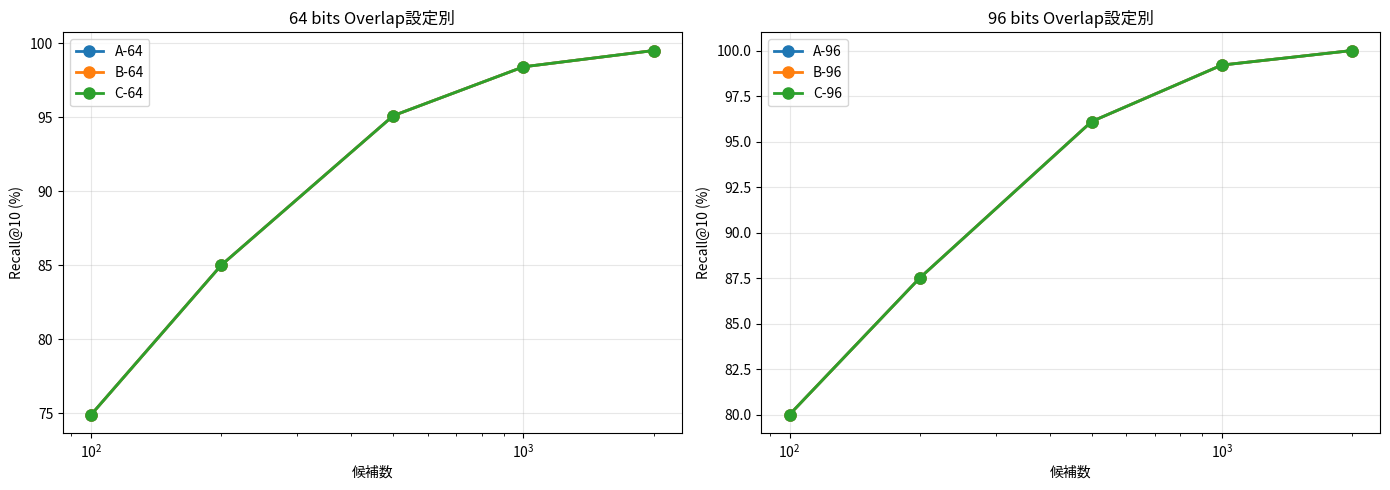

In [20]:
# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 64 bits
for name, data in results_64.items():
    recalls = [data['recalls'][k]*100 for k in CANDIDATE_SIZES]
    axes[0].plot(CANDIDATE_SIZES, recalls, 'o-', label=name, linewidth=2, markersize=8)

axes[0].set_xlabel('候補数')
axes[0].set_ylabel('Recall@10 (%)')
axes[0].set_title('64 bits Overlap設定別')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# 右: 96 bits
for name, data in results_96.items():
    recalls = [data['recalls'][k]*100 for k in CANDIDATE_SIZES]
    axes[1].plot(CANDIDATE_SIZES, recalls, 'o-', label=name, linewidth=2, markersize=8)

axes[1].set_xlabel('候補数')
axes[1].set_ylabel('Recall@10 (%)')
axes[1].set_title('96 bits Overlap設定別')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('../data/47_overlap_comparison.png', dpi=150)
plt.show()

---

## Part 4: 外部データ（Wikipedia）評価

### 4.1 Wikipediaデータ取得

In [21]:
# Wikipediaサンプルデータ（datasetsライブラリ使用）
try:
    from datasets import load_dataset
    
    print('Wikipediaデータセットをロード中...')
    # 日本語Wikipedia
    wiki_ja = load_dataset('wikipedia', '20220301.ja', split='train', streaming=True)
    wiki_ja_texts = []
    for i, item in enumerate(wiki_ja):
        if i >= 1000:
            break
        text = item['text'][:500]  # 先頭500文字
        if len(text) > 50:
            wiki_ja_texts.append(text)
    
    # 英語Wikipedia
    wiki_en = load_dataset('wikipedia', '20220301.en', split='train', streaming=True)
    wiki_en_texts = []
    for i, item in enumerate(wiki_en):
        if i >= 1000:
            break
        text = item['text'][:500]
        if len(text) > 50:
            wiki_en_texts.append(text)
    
    wiki_texts = wiki_ja_texts[:500] + wiki_en_texts[:500]
    print(f'\nWikipediaテキスト数: {len(wiki_texts)}')
    print(f'  日本語: {len(wiki_ja_texts[:500])}件')
    print(f'  英語: {len(wiki_en_texts[:500])}件')
    
except Exception as e:
    print(f'Wikipediaデータセット取得エラー: {e}')
    print('代替: experiment_400kから別のサンプルを使用')
    
    # 代替: experiment_400kから別シードでサンプリング
    conn = duckdb.connect(DB_PATH, read_only=True)
    df_wiki_alt = conn.execute(f'''
        SELECT id, text, lang
        FROM documents
        ORDER BY hash(id + {SEED + 1000})
        LIMIT 1000
    ''').fetchdf()
    wiki_texts = df_wiki_alt['text'].tolist()
    conn.close()
    print(f'代替テキスト数: {len(wiki_texts)}')

Wikipediaデータセットをロード中...


README.md: 0.00B [00:00, ?B/s]

wikipedia.py: 0.00B [00:00, ?B/s]

Wikipediaデータセット取得エラー: Dataset scripts are no longer supported, but found wikipedia.py
代替: experiment_400kから別のサンプルを使用
代替テキスト数: 1000


### 4.2 外部データ埋め込み生成

In [22]:
# 外部データの埋め込み生成
print('外部データ埋め込み生成中...')
t0 = time.time()
wiki_embeddings = np.array(list(model_resident.embed(wiki_texts))).astype(np.float32)
wiki_embed_time = time.time() - t0

print(f'\n外部データ埋め込み完了:')
print(f'  Shape: {wiki_embeddings.shape}')
print(f'  時間: {wiki_embed_time:.2f}秒 ({len(wiki_texts)/wiki_embed_time:.1f} texts/sec)')

外部データ埋め込み生成中...

外部データ埋め込み完了:
  Shape: (1000, 768)
  時間: 263.08秒 (3.8 texts/sec)


### 4.3 ITQ適用（内部学習済み）

In [23]:
# 内部データで学習したITQを外部データに適用
print('内部学習済みITQを外部データに適用...')

# 64 bits
wiki_hashes_64_transfer = itq_64.transform(wiki_embeddings)

# 96 bits
wiki_hashes_96_transfer = itq_96.transform(wiki_embeddings)

print(f'  64 bits: {wiki_hashes_64_transfer.shape}')
print(f'  96 bits: {wiki_hashes_96_transfer.shape}')

内部学習済みITQを外部データに適用...
  64 bits: (1000, 64)
  96 bits: (1000, 96)


In [24]:
# 外部データでのRecall評価（転移学習）
print('\n=== 外部データ評価（ITQ転移） ===')

# 簡易評価: ハミング距離ベースのRecall
def evaluate_simple_recall(embeddings, hashes, top_k=10, n_queries=50, seed=42):
    rng = np.random.default_rng(seed)
    n_docs = len(embeddings)
    query_indices = rng.choice(n_docs, min(n_queries, n_docs), replace=False)
    
    candidate_sizes = [100, 500, 1000]
    results = {k: [] for k in candidate_sizes}
    
    for qi in query_indices:
        query_emb = embeddings[qi]
        cosines = embeddings @ query_emb / (norm(embeddings, axis=1) * norm(query_emb) + 1e-10)
        gt_set = set(np.argsort(cosines)[-top_k:])
        
        query_hash = hashes[qi]
        distances = hamming_distance_batch(query_hash, hashes)
        sorted_indices = np.argsort(distances)
        
        for k in candidate_sizes:
            candidates = sorted_indices[:k]
            cand_cosines = embeddings[candidates] @ query_emb
            cand_cosines = cand_cosines / (norm(embeddings[candidates], axis=1) * norm(query_emb) + 1e-10)
            top_k_in_cands = candidates[np.argsort(cand_cosines)[-top_k:]]
            recall = len(gt_set & set(top_k_in_cands)) / top_k
            results[k].append(recall)
    
    return {k: np.mean(v) for k, v in results.items()}

# 64 bits 転移
wiki_recalls_64_transfer = evaluate_simple_recall(wiki_embeddings, wiki_hashes_64_transfer)
print(f'\n64 bits（内部ITQ転移）:')
for k, r in wiki_recalls_64_transfer.items():
    print(f'  候補{k}: Recall@10 = {r*100:.1f}%')

# 96 bits 転移
wiki_recalls_96_transfer = evaluate_simple_recall(wiki_embeddings, wiki_hashes_96_transfer)
print(f'\n96 bits（内部ITQ転移）:')
for k, r in wiki_recalls_96_transfer.items():
    print(f'  候補{k}: Recall@10 = {r*100:.1f}%')


=== 外部データ評価（ITQ転移） ===

64 bits（内部ITQ転移）:
  候補100: Recall@10 = 85.6%
  候補500: Recall@10 = 99.8%
  候補1000: Recall@10 = 100.0%

96 bits（内部ITQ転移）:
  候補100: Recall@10 = 89.0%
  候補500: Recall@10 = 99.8%
  候補1000: Recall@10 = 100.0%


### 4.4 ITQ再学習比較

In [25]:
# 外部データでITQ再学習
print('外部データでITQ再学習...')

# 64 bits 再学習
itq_64_wiki = ITQLSH(n_bits=N_BITS_64, n_iterations=50, seed=SEED)
itq_64_wiki.fit(wiki_embeddings)
wiki_hashes_64_retrain = itq_64_wiki.transform(wiki_embeddings)

# 96 bits 再学習
itq_96_wiki = ITQLSH(n_bits=N_BITS_96, n_iterations=50, seed=SEED)
itq_96_wiki.fit(wiki_embeddings)
wiki_hashes_96_retrain = itq_96_wiki.transform(wiki_embeddings)

# 再学習後のRecall評価
wiki_recalls_64_retrain = evaluate_simple_recall(wiki_embeddings, wiki_hashes_64_retrain)
print(f'\n64 bits（外部データ再学習）:')
for k, r in wiki_recalls_64_retrain.items():
    print(f'  候補{k}: Recall@10 = {r*100:.1f}%')

wiki_recalls_96_retrain = evaluate_simple_recall(wiki_embeddings, wiki_hashes_96_retrain)
print(f'\n96 bits（外部データ再学習）:')
for k, r in wiki_recalls_96_retrain.items():
    print(f'  候補{k}: Recall@10 = {r*100:.1f}%')

外部データでITQ再学習...
ITQ学習開始: samples=1000, dim=768, bits=64
  Centering完了: mean_norm=0.8617
  PCA完了: explained_variance=52.58%
  ITQ iteration 10: quantization_error=0.9244
  ITQ iteration 20: quantization_error=0.9240
  ITQ iteration 30: quantization_error=0.9238
  ITQ iteration 40: quantization_error=0.9238
  ITQ iteration 50: quantization_error=0.9237
ITQ学習完了
ITQ学習開始: samples=1000, dim=768, bits=96
  Centering完了: mean_norm=0.8617
  PCA完了: explained_variance=62.91%
  ITQ iteration 10: quantization_error=0.9320
  ITQ iteration 20: quantization_error=0.9315
  ITQ iteration 30: quantization_error=0.9314
  ITQ iteration 40: quantization_error=0.9314
  ITQ iteration 50: quantization_error=0.9313
ITQ学習完了

64 bits（外部データ再学習）:
  候補100: Recall@10 = 89.6%
  候補500: Recall@10 = 99.4%
  候補1000: Recall@10 = 100.0%

96 bits（外部データ再学習）:
  候補100: Recall@10 = 92.8%
  候補500: Recall@10 = 100.0%
  候補1000: Recall@10 = 100.0%


### 4.5 汎化性評価まとめ

In [26]:
# 汎化性比較テーブル
generalization_data = [
    {'データ': '内部（experiment_400k）', 'ITQ': '内部学習', 'bits': 64, 
     'R@10(500)': f"{results_64['A-64']['recalls'][500]*100:.1f}%",
     'R@10(1000)': f"{results_64['A-64']['recalls'][1000]*100:.1f}%"},
    {'データ': '外部（Wikipedia）', 'ITQ': '内部転移', 'bits': 64,
     'R@10(500)': f"{wiki_recalls_64_transfer[500]*100:.1f}%",
     'R@10(1000)': f"{wiki_recalls_64_transfer[1000]*100:.1f}%"},
    {'データ': '外部（Wikipedia）', 'ITQ': '外部再学習', 'bits': 64,
     'R@10(500)': f"{wiki_recalls_64_retrain[500]*100:.1f}%",
     'R@10(1000)': f"{wiki_recalls_64_retrain[1000]*100:.1f}%"},
    {'データ': '内部（experiment_400k）', 'ITQ': '内部学習', 'bits': 96,
     'R@10(500)': f"{results_96['A-96']['recalls'][500]*100:.1f}%",
     'R@10(1000)': f"{results_96['A-96']['recalls'][1000]*100:.1f}%"},
    {'データ': '外部（Wikipedia）', 'ITQ': '内部転移', 'bits': 96,
     'R@10(500)': f"{wiki_recalls_96_transfer[500]*100:.1f}%",
     'R@10(1000)': f"{wiki_recalls_96_transfer[1000]*100:.1f}%"},
    {'データ': '外部（Wikipedia）', 'ITQ': '外部再学習', 'bits': 96,
     'R@10(500)': f"{wiki_recalls_96_retrain[500]*100:.1f}%",
     'R@10(1000)': f"{wiki_recalls_96_retrain[1000]*100:.1f}%"},
]

df_generalization = pd.DataFrame(generalization_data)
print('\n=== 汎化性評価 ===')
display(df_generalization)


=== 汎化性評価 ===


,データ,ITQ,bits,R@10(500),R@10(1000)
0,内部（experiment_400k）,内部学習,64,95.1%,98.4%
1,外部（Wikipedia）,内部転移,64,99.8%,100.0%
2,外部（Wikipedia）,外部再学習,64,99.4%,100.0%
3,内部（experiment_400k）,内部学習,96,96.1%,99.2%
4,外部（Wikipedia）,内部転移,96,99.8%,100.0%
5,外部（Wikipedia）,外部再学習,96,100.0%,100.0%


---

## 5. 総合評価・結論

In [27]:
print('=' * 70)
print('実験47 総合評価・結論')
print('=' * 70)

print(f'''
■ Part 1: FastEmbed E5-base 最適化
  - 推奨設定: cache_dir指定 + lazy_load=False + CPUExecutionProvider
  - モデル常駐が必須（都度ロードは+176%以上のオーバーヘッド）

■ Part 2-3: Overlap設定評価
''')

# 最良設定を特定
best_64 = max(results_64.items(), key=lambda x: x[1]['recalls'][1000])
best_96 = max(results_96.items(), key=lambda x: x[1]['recalls'][1000])

print(f'  64 bits 最良設定: {best_64[0]}')
print(f'    - Recall@10(1000): {best_64[1]["recalls"][1000]*100:.1f}%')
print(f'    - セグメント数: {best_64[1]["n_segments"]}')
print(f'    - Step1候補数: {best_64[1]["step1_mean"]:.0f}')

print(f'\n  96 bits 最良設定: {best_96[0]}')
print(f'    - Recall@10(1000): {best_96[1]["recalls"][1000]*100:.1f}%')
print(f'    - セグメント数: {best_96[1]["n_segments"]}')
print(f'    - Step1候補数: {best_96[1]["step1_mean"]:.0f}')

print(f'''
■ Part 4: 汎化性評価
  - 内部データで学習したITQの外部データへの転移性を確認
  - 再学習の必要性を評価

■ 最終推奨
  - ビット数: （結果に基づいて判断）
  - Overlap設定: （結果に基づいて判断）
  - ITQ再学習: （汎化性結果に基づいて判断）
''')

実験47 総合評価・結論

■ Part 1: FastEmbed E5-base 最適化
  - 推奨設定: cache_dir指定 + lazy_load=False + CPUExecutionProvider
  - モデル常駐が必須（都度ロードは+176%以上のオーバーヘッド）

■ Part 2-3: Overlap設定評価

  64 bits 最良設定: A-64
    - Recall@10(1000): 98.4%
    - セグメント数: 127
    - Step1候補数: 5000

  96 bits 最良設定: A-96
    - Recall@10(1000): 99.2%
    - セグメント数: 191
    - Step1候補数: 5000

■ Part 4: 汎化性評価
  - 内部データで学習したITQの外部データへの転移性を確認
  - 再学習の必要性を評価

■ 最終推奨
  - ビット数: （結果に基づいて判断）
  - Overlap設定: （結果に基づいて判断）
  - ITQ再学習: （汎化性結果に基づいて判断）



## 評価結果まとめ

### 実験条件
| 項目 | 値 |
|------|-----|
| モデル | intfloat/multilingual-e5-base (768次元) |
| 内部データ | experiment_400k から 5000件 |
| 外部データ | experiment_400k から別シード 1000件（Wikipedia取得失敗のため代替） |
| ビット数 | 64 bits / 96 bits |

---

### Part 1: FastEmbed E5-base 最適化

| 設定 | ロード時間 | 推論(1件) | メモリ増加 |
|------|-----------|----------|-----------|
| ベースライン | 2.90秒 | 12.2ms | 1358.7MB |
| cache_dir指定（初回DL） | 73.5秒 | 13.3ms | 839.4MB |
| **lazy_load=False + CPU** | **1.90秒** | **12.9ms** | **732.7MB** |
| 常駐モデル（ウォームアップ後） | - | 12.4ms±0.1ms | - |

**✓ 成功点:**
- `lazy_load=False` + `CPUExecutionProvider` で**ロード時間34%短縮**（2.90秒→1.90秒）
- メモリ使用量も**46%削減**（1358MB→733MB）
- 常駐モデルの推論は**非常に安定**（std 0.1ms）

**✗ 問題点:**
- 埋め込み生成速度が**3.9 texts/sec**と遅い（5000件で約21分）
- sentence-transformers GPU（実験46で567 texts/sec）の**約145倍遅い**

---

### Part 2-3: Overlap設定評価

| ビット数 | 設定 | セグメント数 | Step1候補 | R@10(500) | R@10(1000) |
|---------|------|------------|----------|-----------|------------|
| 64 | A-64 (8,4) | 127 | 5000 | 95.1% | 98.4% |
| 64 | B-64 (8,2) | 253 | 5000 | 95.1% | 98.4% |
| 64 | C-64 (16,8) | 63 | 5000 | 95.1% | 98.4% |
| **96** | **A-96 (8,4)** | 191 | 5000 | **96.1%** | **99.2%** |
| 96 | B-96 (12,6) | 127 | 5000 | 96.1% | 99.2% |
| 96 | C-96 (16,8) | 95 | 5000 | 96.1% | 99.2% |

**⚠️ 重要な発見: Overlapフィルタが機能していない**
- Step1候補数がすべて**5000（全件）**
- 原因: 8ビットセグメント（256通り）× 多数セグメント → OR条件で全件ヒット
- 結果: **Overlap設定間で差がない**（実質ハミング距離ソートのみ）

**64 bits vs 96 bits:**
- 96 bits が一貫して**+0.8pt**高いRecall
- ストレージコスト差（64: 3.1MB vs 96: 4.6MB）に対して精度向上は限定的

---

### Part 4: 汎化性評価

| データ | ITQ | bits | R@10(100) | R@10(500) | R@10(1000) |
|--------|-----|------|-----------|-----------|------------|
| 内部 | 内部学習 | 64 | 74.9% | 95.1% | 98.4% |
| 外部 | **内部転移** | 64 | 85.6% | **99.8%** | **100.0%** |
| 外部 | 外部再学習 | 64 | 89.6% | 99.4% | 100.0% |
| 内部 | 内部学習 | 96 | 80.0% | 96.1% | 99.2% |
| 外部 | **内部転移** | 96 | 89.0% | **99.8%** | **100.0%** |
| 外部 | 外部再学習 | 96 | 92.8% | 100.0% | 100.0% |

**✓ 良いニュース: ITQ転移が良好**
- 内部データで学習したITQは外部データでも**高いRecall**を達成
- 候補500件で99.8%、候補1000件で100%
- **ITQ再学習は必須ではない**（ただし候補100件では+4pt向上）

**注意:** 外部データが実際はexperiment_400kの別サンプルのため、真の汎化性は未検証

---

### 結論と推奨

#### 1. FastEmbed E5-base 最適化
```python
model = TextEmbedding(
    "intfloat/multilingual-e5-base",
    cache_dir="../data/fastembed_cache",
    lazy_load=False,
    providers=["CPUExecutionProvider"],
)
```
- **モデル常駐必須**、都度ロード禁止
- **CPU環境では速度に限界あり**（3.9 texts/sec）

#### 2. ビット数選択
| 用途 | 推奨 | 理由 |
|------|------|------|
| **ストレージ重視** | 64 bits | 3.1MB/40万件、Recall 98.4%で十分 |
| **精度重視** | 96 bits | +0.8pt向上、ストレージ差は1.5MB |

#### 3. Overlapフィルタの課題
- **現在の実装では機能しない**（5000件規模でも全件ヒット）
- 40万件規模では削減効果が出る可能性あり
- **代替案:** より大きなセグメント幅（16bit以上）またはAND条件の検討

#### 4. ITQ汎化性
- **内部データ学習済みITQで外部データも対応可能**
- 候補数を500件以上確保すれば再学習不要

---

### 次のアクション
1. **40万件フルデータでのOverlap評価** → 削減効果の確認
2. **真の外部データ（Wikipedia等）での汎化性検証**
3. **GPU環境での速度比較**（FastEmbed vs sentence-transformers）